In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt


### Hyperparameters

In [49]:
# 클러스터 갯수
K = 3

# 클러스터 당 샘플 갯수
N_k = 100

# 총 샘플 갯수
N = N_k * K


### Sample generation

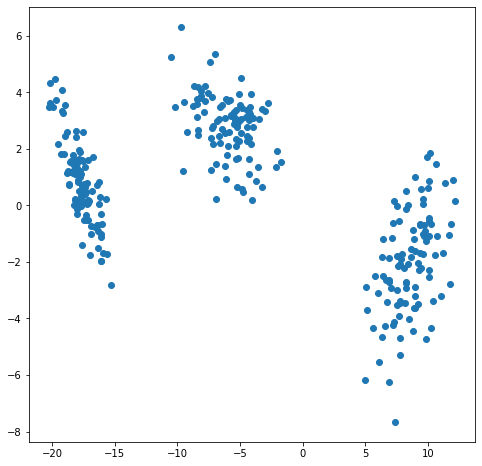

In [50]:
np.random.seed(2020)

samples = []
for _ in range(K):
    # Normal(mean=0, cov=I_2)에서 2D 벡터 하나를 샘플링합니다.
    mean = np.random.normal(size=2) * 10
    
    # wishart distribution에서 샘플링하여 임의의 covariance matrix를 만들어 냅니다.
    cov = scipy.stats.wishart.rvs(3, scale=[[1, 0], [0, 1]])
    
    # 위에서 샘플링한 mean과 covariance를 갖는 multivariate normal distribution에서 N_k개의 샘플을 얻습니다.
    samples.append(np.random.multivariate_normal(mean, cov, size=N_k))
    
# shape: (N, 2), concatenate하여 list를 numpy array로 변환합니다.
samples = np.concatenate(samples, axis=0)

# Visualizaiton
plt.figure(figsize=[8, 8])
plt.scatter(samples[:, 0], samples[:, 1])
plt.show()


### E-step
$\gamma\left(z_{n k}\right)=\frac{\pi_{k} N\left(x_{n} | \mu_{k}, \Sigma_{k}\right)}{\sum_{j=1}^{K} \pi_{j} N\left(x_{n} | \mu_{j}, \Sigma_{j}\right)}$

In [51]:
def E_step(pis, means, covs, samples):
    '''
    각 sample들이 각 클러스터들에 속할 확률을 구합니다.
    
    arguments
    pis: (K), K개 클러스터의 coefficient
    means: (K, 2), K개 클러스터의 mean
    covs: (K, 2, 2), K개 클러스터의 covariance matrix
    samples: (N, 2), N개 샘플들의 벡터
    
    returns
    responsibilities: (N, K), N개 샘플이 K개 클러스터에 속할 확률
    '''
    
    # shape: (N, K), 각 샘플들이 K개 클러스터에 속할 확률을 저장할 변수를 만듭니다.
    responsibilities = np.zeros([N, K])

    for k in range(K):
        # shape: (N), prior와 likelihood를 곱하여 responsibility를 구합니다.
        responsibility = pis[k] * scipy.stats.multivariate_normal.pdf(samples, mean=means[k], cov=covs[k])
        responsibilities[:, k] = responsibility
        
    # Normalization
    responsibilities = responsibilities / np.sum(responsibilities, axis=1)[:, None]
        
    return responsibilities


### M-step
$\begin{array}{l}
{\pi_{k}^{n e w}=\frac{N_{k}}{N}, \mu_{k}^{n e w}=\frac{1}{N_{k}} \sum_{n=1}^{N} \gamma\left(z_{n k}\right) x_{n}, \Sigma_{k}^{n e w}=\frac{1}{N_{k}} \sum_{n=1}^{N} \gamma\left(z_{n k}\right)\left(x_{n}-\mu_{k}^{n e w}\right)\left(x_{n}-\mu_{k}^{n e w}\right)^{T}} \\
{\text {where } N_{k}=\sum_{n=1}^{N} \gamma\left(z_{n k}\right)}
\end{array}$

In [52]:
def M_step(responsibilities, samples):
    '''
    E-step에서 정한 클러스터를 기준으로 각각 mean을 구합니다.
    
    arguments
    responsibilities: (N, K), N개 샘플이 K개 클러스터에 속할 확률
    samples: (N, 2), N개 샘플들의 벡터
    
    returns
    pis: (K), K개 클러스터의 coefficient
    means: (K, 2), K개 클러스터의 mean
    covs: (K, 2, 2), K개 클러스터의 covariance matrix
    '''
    
    for k in range(K):
        # shape: scalar, 클러스터 당 responsibility들의 합
        N_k = np.sum(responsibilities[:, k])
        
        # shape: scalar, k번째 클러스터의 coefficient
        pis[k] = N_k / N
        
        # shape: (2), k번째 클러스터의 mean
        means[k] = np.sum(responsibilities[:, k][:, None] * samples, axis=0) / N_k
        
        # shape: (N, 2, 1), 샘플들과 mean간의 차
        diffs = (samples - means[k])[:, :, None]
        
        # k번째 클러스터의 covariance matrix
        cov = np.zeros([2, 2])
        for n in range(N):
            cov += responsibilities[n, k] * diffs[n] @ diffs[n].T
        covs[k] = cov / N_k
        
    return pis, means, covs


In [53]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib import colors
from matplotlib import cm

# reference : https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(ax, mean, cov, n_std=3.0, facecolor='none', **kwargs):
    
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean[0], mean[1])

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def plot(ax, samples, responsibilities, means, covs, title):
    cluster_colors = cm.get_cmap('Set1').colors
     
    for k in range(K):
        rgba = colors.to_rgba(cluster_colors[k])
        rgba_n = np.array([rgba for _ in range(N)])
        rgba_n[:, 3] = responsibilities[:, k] * 0.8
        
        ax.scatter(samples[:, 0], samples[:, 1], color=rgba_n)
        ax.scatter(means[k, 0], means[k, 1], marker='x', color='black')
        confidence_ellipse(ax, means[k], covs[k], edgecolor=rgba)
    
    ax.set_title(title)
    
    

### EM Iteration

iteration : 0


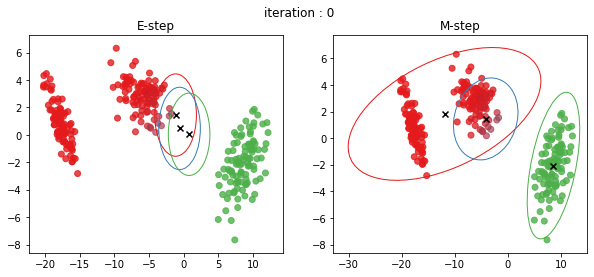

iteration : 10


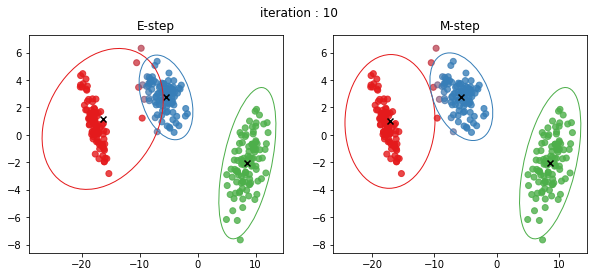

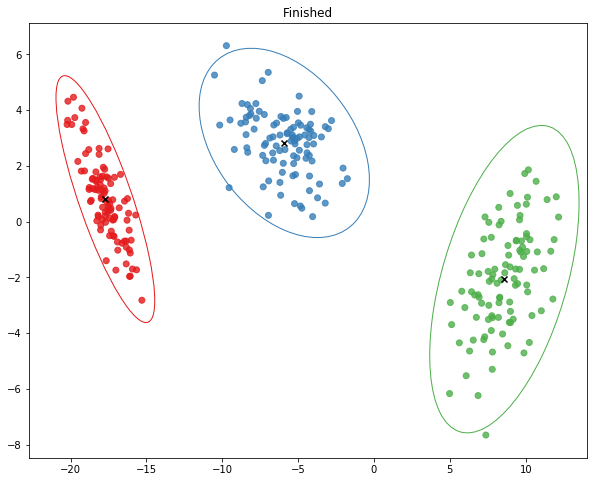

In [54]:
'''
Parameter Initialization
'''
# K개의 coefficient들을 균등하게 초기화합니다.
pis = np.ones(K) / K

# K개의 mean들을 랜덤하게 초기화합니다.
means = np.random.normal(size=[K, 2])

# K개의 covariance matrix들을 indentity로 초기화합니다.
covs = [np.array([[1, 0], [0, 1]]) for _ in range(K)]

for step in range(20):
    
    #E-step: 각 sample들이 각 클러스터들에 속할 확률을 구합니다.
    responsibilities = E_step(pis, means, covs, samples)
    
    if step % 10 == 0:
        print('iteration :', step)
        fig, axs = plt.subplots(1, 2, figsize=[10, 4])
        fig.suptitle('iteration : ' + str(step))
        plot(axs[0], samples, responsibilities, means, covs, 'E-step')
    
    # M-step: E-step에서 정한 responsibility를 기준으로 coefficient, mean과 covariance matrix들을 업데이트합니다.
    pis, means, covs = M_step(responsibilities, samples)
        
    if step % 10 == 0:
        plot(axs[1], samples, responsibilities, means, covs, 'M-step')
        plt.show()

fig, ax = plt.subplots(1, 1, figsize=[10, 8])
plot(ax, samples, responsibilities, means, covs, 'Finished')
plt.show()
